In [1]:
#use the Q2 2016 data first
import sys
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import seaborn

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#ERCOT data
lds = datetime.datetime(year=2016, month=2, day=29, hour=0, minute=0) #lines 1415 to 1439
lde = datetime.datetime(year=2016, month=2, day=29, hour=23, minute=0)

path = "/home/chase/projects/peakload/data/ercot/"
ercot2017 = pd.read_excel(path + "native_Load_2017.xlsx")
ercot2016 = pd.read_excel(path + "native_Load_2016.xlsx") #leap year
ercot2016.drop(ercot2016.index[1415:1439], inplace=True)

ercot2015 = pd.read_excel(path + "native_Load_2015.xls")
ercot2014 = pd.read_excel(path + "2014_ERCOT_Hourly_Load_Data.xls")
ercot2013 = pd.read_excel(path + "2013_ERCOT_Hourly_Load_Data.xls")
ercot2012 = pd.read_excel(path + "2012_ERCOT_Hourly_Load_Data.xls") #leap year
ercot2012.drop(ercot2012.index[1415:1439], inplace=True)

ercot2011 = pd.read_excel(path + "2011_ERCOT_Hourly_Load_Data.xls")
ercot2010 = pd.read_excel(path + "2010_ERCOT_Hourly_Load_Data.xls")

ercotdata = list(ercot2010['ERCOT']) + list(ercot2011['ERCOT']) + list(ercot2012['ERCOT']) + list(ercot2013['ERCOT']) + list(ercot2014['ERCOT']) + list(ercot2015['ERCOT']) + list(ercot2016['ERCOT']) + list(ercot2017['ERCOT'])

In [3]:
yearly_data = [ercot2010, ercot2011, ercot2012, ercot2013, ercot2014, ercot2015, ercot2016, ercot2017]

In [4]:
yearly_loads = np.zeros((8,8760))

for i in range(len(yearly_data)):
    yearly_loads[i,:] = np.array(yearly_data[i]['ERCOT'])

#need to drop leap days

In [5]:
avgs = np.nanmean(yearly_loads, axis=1)
avgs = avgs[:,np.newaxis]

In [8]:
fs = 18
fs_ = 20
_fs = 16

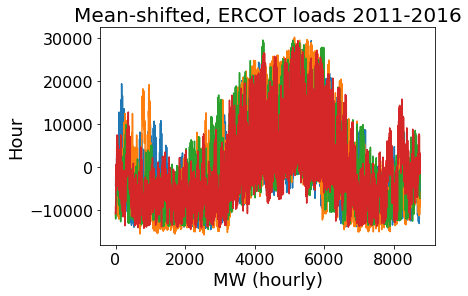

In [9]:
ax = plt.axes()
plt.title("Mean-shifted, ERCOT loads 2011-2016", fontsize=fs_)
plt.ylabel("Hour", fontsize=fs)
plt.xlabel("MW (hourly)", fontsize=fs)
plt.setp(ax.get_xticklabels(), fontsize=_fs)
plt.setp(ax.get_yticklabels(), fontsize=_fs)
plt.plot((yearly_loads - avgs)[0,:])
plt.plot((yearly_loads - avgs)[1,:])
plt.plot((yearly_loads - avgs)[2,:])
plt.plot((yearly_loads - avgs)[3,:])
plt.show()

In [7]:
peaks_i = np.nanargmax(yearly_loads,axis=1)
peaks = np.zeros((yearly_loads.shape[0],1))
for i in range(yearly_loads.shape[0]):
    peaks[i] = yearly_loads[i, peaks_i[i]]

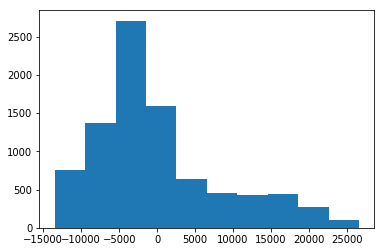

In [10]:
pmf_hat = np.nanmean((yearly_loads - avgs), axis=0)
plt.hist(pmf_hat)
plt.show()

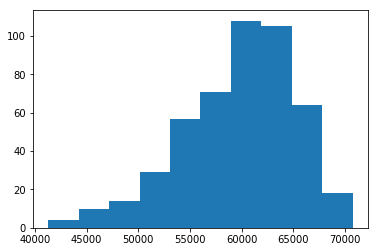

In [11]:
#generate output data with filter, 30 days at 24 hours apart across 6 years
out = []
for i in range(60):
    h = yearly_loads[:,4000 + i*24]
    for val in h:
        out.append(val)
plt.hist(out)
plt.show()

In [12]:
yearly_loads.shape

(8, 8760)

In [13]:
hourly_cmfs = []
hs = 8759

#window width in days, 24 hour gaps between sampled hours
days = 30

for i in range(hs):
    out = []
    for j in range(days):
        h = yearly_loads[:,i - j*24]
        for val in h:
            out.append(val)
    hourly_cmfs.append(out)

In [14]:
len(hourly_cmfs[0])

240

In [11]:
train_data = yearly_loads[0:6,:]
train_data_vec = yearly_loads[0,:]
for j in range(1,train_data.shape[0]):
    train_data_vec = np.concatenate((train_data_vec, train_data[j,:]), axis= 0)

val_data = yearly_loads[-1,:]

train_data_labels = np.zeros((train_data.shape[0]*train_data.shape[1], 1))
val_data_labels = np.zeros((val_data.shape[0], 1))

for i in range(train_data_labels.shape[0]):
    year = int(np.floor(float(i)/8760.0))
    greater = np.sum([1 for k in yearly_loads[year,:] if k >= train_data_vec[i]])/float(yearly_loads.shape[1])
    train_data_labels[i] = 1.0 - greater
        
for i in range(val_data_labels.shape[0]):
    year = train_data.shape[0] - 1
    greater = np.sum([1 for k in yearly_loads[year,:] if k >= val_data[i]])/float(yearly_loads.shape[1])
    val_data_labels[i] = 1.0 - greater

In [12]:
train_data_labels_arr = np.reshape(train_data_labels, (6,8760))
model = np.mean(train_data_labels_arr, axis=0)

In [15]:
train_data_arr = np.mean(train_data, axis=0)

In [21]:
model_pairs = np.concatenate((train_data_arr[:,np.newaxis], model[:,np.newaxis]), axis=1)

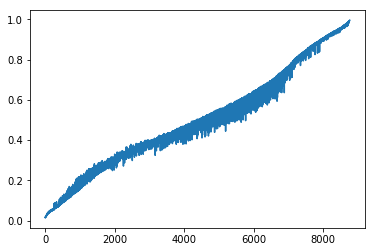

In [26]:
plt.plot(model[np.argsort(train_data_arr)])

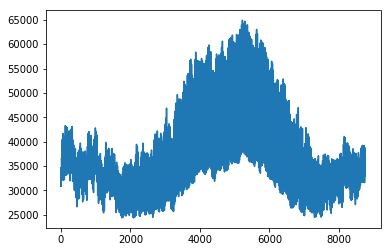

In [16]:
plt.plot(train_data_arr)

In [14]:
model

array([0.28881279, 0.27545662, 0.26284247, ..., 0.43932648, 0.379414  ,
       0.33491248])

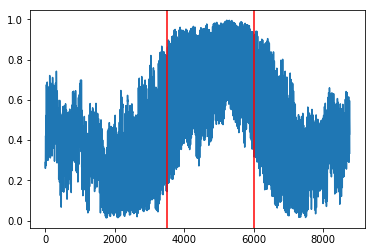

In [13]:
plt.plot(model)
plt.axvline(x=3500, color="red")
plt.axvline(x=6000, color="red")
plt.show()

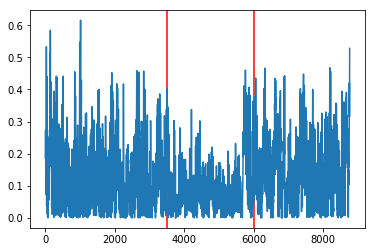

In [11]:
loss = np.abs((val_data_labels - model[:,np.newaxis]))
plt.axvline(x=3500, color="red")
plt.axvline(x=6000, color="red")
plt.plot(loss)

In [12]:
print(val_data_labels.shape)
print(model.shape)

(8760, 1)
(8760,)


In [10]:
plt.plot(model)

NameError: name 'model' is not defined

In [17]:
train_data_labels.shape

(52560, 1)

In [13]:
thresh_losses_low = []
thresh_low = 0.85

thresh_losses_high = []
thresh_high = 0.95

for i in range(val_data_labels.shape[0]):
    v = val_data_labels[i,0]
    if v >= thresh_low:
        thresh_losses_low.append(np.abs(v - model[i]))
    if v >= thresh_high:
        thresh_losses_high.append(np.abs(v - model[i]))
        
mean_thresh_loss_low = np.mean(thresh_losses_low)
mean_thresh_loss_high = np.mean(thresh_losses_high)

In [14]:
print(mean_thresh_loss_high)
print(mean_thresh_loss_low)

0.046894799357
0.0763237294756


In [15]:
thresh_losses_low = []
thresh_low = 0.85

thresh_losses_high = []
thresh_high = 0.95

for i in range(val_data_labels.shape[0]):
    v = val_data_labels[i,0]
    if v >= thresh_low:
        thresh_losses_low.append(np.abs(v - model[i]) * np.exp(v))
    if v >= thresh_high:
        thresh_losses_high.append(np.abs(v - model[i]) * np.exp(v))
        
mean_thresh_loss_low = np.mean(thresh_losses_low)
mean_thresh_loss_high = np.mean(thresh_losses_high)

In [16]:
print(mean_thresh_loss_high)
print(mean_thresh_loss_low)

0.1241025937
0.19049418144


In [16]:
#precision
pos = 0
true_pos = 0
for i in range(val_data_labels.shape[0]):
    v = model[i]
    if v >= thresh_low:
        pos += 1
        comp_val = val_data_labels[i,0]
        if comp_val >= thresh_low:
            true_pos += 1
            
print("binary precision: " + str(float(true_pos)/float(pos)))

#recall
true_pos = 0
pred_pos = 0
for i in range(val_data_labels.shape[0]):
    v = val_data_labels[i,0]
    if v >= thresh_low:
        true_pos += 1
        pred_val = model[i]
        if pred_val >= thresh_low:
            pred_pos += 1
            
print("binary recall: " + str(float(pred_pos)/float(true_pos)))
    

binary precision: 0.8442760942760943
binary recall: 0.6827773995915589


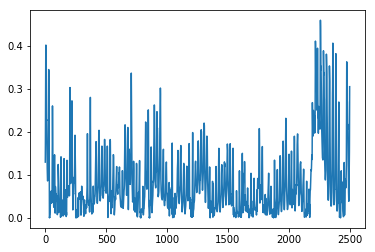

In [40]:
loss = np.abs((val_data_labels - model[:,np.newaxis])[3500:6000])
plt.plot(loss)

In [41]:
np.mean(np.abs((val_data_labels - model[:,np.newaxis])[3500:6000]))

0.081602754946727557

In [22]:
l_val_data = list(val_data)

In [23]:
l_val_data = sorted(l_val_data)

In [55]:
fs = 18
fs_ = 20
_fs = 16

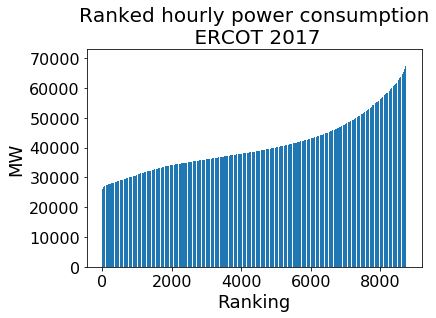

In [58]:
#1.0/float(len(l_val_data))
#ranks = list(np.arange(0,1,1.0/float(len(l_val_data))))
ranks = np.arange(0,len(l_val_data))

ax = plt.axes()
plt.bar(ranks,l_val_data)
plt.title("Ranked hourly power consumption\n ERCOT 2017", fontsize=fs_)
plt.ylabel("MW", fontsize=fs)
plt.xlabel("Ranking", fontsize=fs)
plt.setp(ax.get_xticklabels(), fontsize=_fs)
plt.setp(ax.get_yticklabels(), fontsize=_fs)
plt.show()

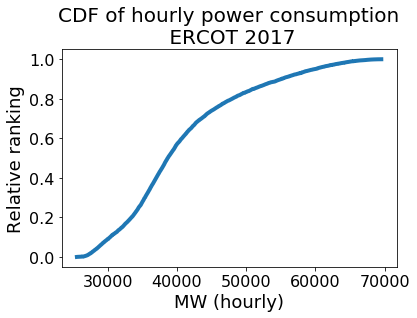

In [57]:
ax = plt.axes()
plt.plot(l_val_data, list(np.arange(0,1,1.0/float(len(l_val_data)))), linewidth=4)
plt.title("CDF of hourly power consumption\n ERCOT 2017", fontsize=fs_)
plt.ylabel("Relative ranking", fontsize=fs)
plt.xlabel("MW (hourly)", fontsize=fs)
plt.setp(ax.get_xticklabels(), fontsize=_fs)
plt.setp(ax.get_yticklabels(), fontsize=_fs)
plt.show()

In [66]:
peaks = np.argpartition(val_data, -4)[-4:]
print(peaks)

[4815 5006 5007 5008]


In [78]:
np.e

2.718281828459045

In [72]:
hours = np.arange(0, len(val_data), 1)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

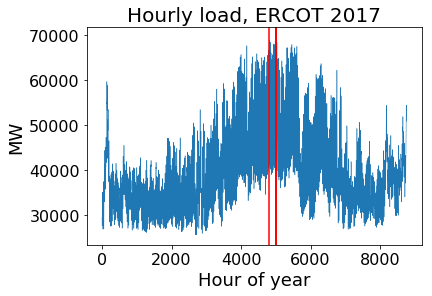

In [73]:
ax = plt.axes()
plt.plot(hours, val_data, linewidth=0.5)
plt.title("Hourly load, ERCOT 2017", fontsize=fs_)
plt.ylabel("MW", fontsize=fs)
plt.xlabel("Hour of year", fontsize=fs)
for p in peaks:
    plt.axvline(p, color="red")
plt.setp(ax.get_xticklabels(), fontsize=_fs)
plt.setp(ax.get_yticklabels(), fontsize=_fs)

(5000, 5010)

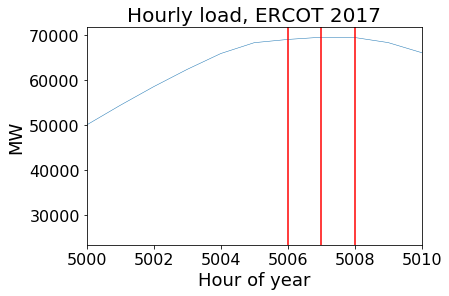

In [77]:
ax = plt.axes()
plt.plot(hours, val_data, linewidth=0.5)
plt.title("Hourly load, ERCOT 2017", fontsize=fs_)
plt.ylabel("MW", fontsize=fs)
plt.xlabel("Hour of year", fontsize=fs)
for p in peaks:
    plt.axvline(p, color="red")
plt.setp(ax.get_xticklabels(), fontsize=_fs)
plt.setp(ax.get_yticklabels(), fontsize=_fs)
plt.xlim(5000, 5010)

In [ ]:
#trying a stock price tutorial

In [ ]:
#functions for putting data into input sized arrays

    def _prepare_data(self, seq):
        # split into items of input_size
        seq = [np.array(seq[i * self.input_size: (i + 1) * self.input_size])
               for i in range(len(seq) // self.input_size)]

        if self.normalized:
            seq = [seq[0] / seq[0][0] - 1.0] + [
                curr / seq[i][-1] - 1.0 for i, curr in enumerate(seq[1:])]

        # split into groups of num_steps
        X = np.array([seq[i: i + self.num_steps] for i in range(len(seq) - self.num_steps)])
        y = np.array([seq[i + self.num_steps] for i in range(len(seq) - self.num_steps)])

        train_size = int(len(X) * (1.0 - self.test_ratio))
        train_X, test_X = X[:train_size], X[train_size:]
        train_y, test_y = y[:train_size], y[train_size:]
        return train_X, train_y, test_X, test_y

#randomly shuffling the data and inputting into batches
    
    def generate_one_epoch(self, batch_size):
        num_batches = int(len(self.train_X)) // batch_size
        if batch_size * num_batches < len(self.train_X):
            num_batches += 1

        batch_indices = range(num_batches)
        random.shuffle(batch_indices)
        for j in batch_indices:
            batch_X = self.train_X[j * batch_size: (j + 1) * batch_size]
            batch_y = self.train_y[j * batch_size: (j + 1) * batch_size]
            assert set(map(len, batch_X)) == {self.num_steps}
            yield batch_X, batch_y

In [69]:
input_size = 1
num_steps = 24*7
lstm_size = 128
num_layers = 1
keep_prob = 0.8

batch_size = 64
init_learning_rate = 0.001
learning_rate_decay = 0.99
init_epoch = 5
max_epoch = 50

seq = train_data_vec
labels = train_data_labels[:,0]

seq = [ np.array(seq[i*input_size:(i + 1)*input_size]) for i in range(seq.shape[0] // input_size) ]
seq_labels = [ np.array(labels[i*input_size:(i + 1)*input_size]) for i in range(labels.shape[0] // input_size) ]

# split into groups of num_steps
train_X = np.array([seq[i: i + num_steps] for i in range(len(seq) - num_steps)])
train_y = np.array([seq_labels[i + num_steps] for i in range(len(seq_labels) - num_steps)]) #need shift factor


test_seq = val_data
test_labels = val_data_labels

test_seq = [ np.array(test_seq[i*input_size:(i + 1)*input_size]) for i in range(test_seq.shape[0] // input_size) ]
test_seq_labels = [ np.array(test_labels[i*input_size:(i + 1)*input_size]) for i in range(test_labels.shape[0] // input_size) ]

# split into groups of num_steps
test_X = np.array([test_seq[i: i + num_steps] for i in range(len(test_seq) - num_steps)])
test_y = np.array([test_seq_labels[i + num_steps] for i in range(len(test_seq_labels) - num_steps)])

#train_size = int(len(X) * (1.0 - test_ratio))
#train_X, test_X = X[:train_size], X[train_size:]
#train_y, test_y = y[:train_size], y[train_size:]


In [80]:
import random

num_batches = len(train_X) // batch_size
if batch_size * num_batches < len(train_X):
    num_batches += 1

batch_indices = list(np.arange(num_batches))
random.shuffle(batch_indices)
for j in batch_indices:
    batch_X = train_X[j*batch_size:(j+1)*batch_size]
    batch_y = train_y[j*batch_size:(j+1)*batch_size]
    #assert(set(map(len, batch_X)) == {num_steps})
    #yield(batch_X, batch_y)

def generate_one_epoch(self, batch_size):
    num_batches = int(len(self.train_X)) // batch_size
    if batch_size * num_batches < len(self.train_X):
        num_batches += 1

    batch_indices = range(num_batches)
    random.shuffle(batch_indices)
    for j in batch_indices:
        batch_X = self.train_X[j * batch_size: (j + 1) * batch_size]
        batch_y = self.train_y[j * batch_size: (j + 1) * batch_size]
        assert set(map(len, batch_X)) == {self.num_steps}
        yield batch_X, batch_y

In [88]:
batch_X.shape #batches, window length, input element size

(64, 168, 1)

In [64]:
class RNNConfig():
    input_size = 1
    num_steps = 24*7
    lstm_size = 128
    num_layers = 1
    keep_prob = 0.8

    batch_size = 64
    init_learning_rate = 0.001
    learning_rate_decay = 0.99
    init_epoch = 5
    max_epoch = 50

    def to_dict(self):
        dct = self.__class__.__dict__
        return {k: v for k, v in dct.iteritems() if not k.startswith('__') and not callable(v)}

    def __str__(self):
        return str(self.to_dict())

    def __repr__(self):
        return str(self.to_dict())


DEFAULT_CONFIG = RNNConfig()
print "Default configuration:", DEFAULT_CONFIG.to_dict()

#DATA_DIR = "data"
#LOG_DIR = "logs"
#MODEL_DIR = "models"

In [57]:
input_size = 24*7
num_steps = 1
output_size = 24

In [58]:
seq = train_data_vec

In [59]:
seq = [np.array(seq[i * input_size: (i + 1) * input_size]) 
       for i in range(len(seq) // input_size)]

In [60]:
X = np.array([seq[i: i + num_steps] for i in range(len(seq) - num_steps)]) #input data
#y = np.array([seq[i + num_steps] for i in range(len(seq) - num_steps)]) #labels

In [61]:
X.shape

(311, 1, 168)

(array([ 32094.064435,  32171.322546,  32241.752463,  32459.193227,
         33123.751047,  34314.953512,  35498.596749]),
 array([ 36028.145673,  36092.666893,  35765.174232,  34908.264048,
         33582.90132 ,  32038.688729,  30502.942522]),
 array([ 32094.064435,  32171.322546,  32241.752463,  32459.193227,
         33123.751047,  34314.953512,  35498.596749,  36028.145673,
         36092.666893,  35765.174232,  34908.264048,  33582.90132 ,
         32038.688729,  30502.942522]))

In [62]:
import tensorflow as tf
tf.reset_default_graph()
lstm_graph = tf.Graph()


In [66]:
with lstm_graph.as_default():
        # Dimension = (
    #     number of data examples, 
    #     number of input in one computation step, 
    #     number of numbers in one input
    # )
    # We don't know the number of examples beforehand, so it is None.
    inputs = tf.placeholder(tf.float32, [None, config.num_steps, config.input_size])
    targets = tf.placeholder(tf.float32, [None, config.input_size])
    learning_rate = tf.placeholder(tf.float32, None, name="learning_rate")
    
    def _create_one_cell():
        return tf.contrib.rnn.LSTMCell(config.lstm_size, state_is_tuple=True)
        if config.keep_prob < 1.0:
            lstm_cell = tf.contrib.rnn.DropoutWrapper(lstm_cell, output_keep_prob=config.keep_prob)
        return lstm_cell
        
    cell = tf.contrib.rnn.MultiRNNCell(
        [_create_one_cell() for _ in range(config.num_layers)], 
        state_is_tuple=True
    ) if config.num_layers > 1 else _create_one_cell()
    
    val, _ = tf.nn.dynamic_rnn(cell, inputs, dtype=tf.float32)

    # Before transpose, val.get_shape() = (batch_size, num_steps, lstm_size)
    # After transpose, val.get_shape() = (num_steps, batch_size, lstm_size)
    val = tf.transpose(val, [1, 0, 2])
    # last.get_shape() = (batch_size, lstm_size)
    last = tf.gather(val, int(val.get_shape()[0]) - 1, name="last_lstm_output")
    
    weight = tf.Variable(tf.truncated_normal([config.lstm_size, config.input_size]))
    bias = tf.Variable(tf.constant(0.1, shape=[config.input_size]))
    prediction = tf.matmul(last, weight) + bias
    
    tf.summary.histogram("last_lstm_output", last)
    tf.summary.histogram("weights", weight)
    tf.summary.histogram("biases", bias)

    with tf.name_scope("train"):
        # loss = -tf.reduce_sum(targets * tf.log(tf.clip_by_value(prediction, 1e-10, 1.0)))
        loss = tf.reduce_mean(tf.abs(prediction - targets), name="loss_mae")
        optimizer = tf.train.AdamOptimizer(learning_rate)
        minimize = optimizer.minimize(loss, name="loss_mae_adam_minimize")
        tf.summary.scalar("loss_mae", loss)

    # Operators to use after restoring the model
    for op in [prediction, loss]:
        tf.add_to_collection('ops_to_restore', op)
    
    

/home/chase/applications/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [67]:
learning_rates_to_use = [
    config.init_learning_rate * (
        config.learning_rate_decay ** max(float(i + 1 - config.init_epoch), 0.0)
    ) for i in range(config.max_epoch)]

with tf.Session(graph=lstm_graph) as sess:
    tf.global_variables_initializer().run()
    
    for epoch_step in range(config.max_epoch):
        current_lr = learning_rates_to_use[epoch_step]

        #https://github.com/lilianweng/stock-rnn/blob/master/model_rnn.py
        for batch_X, batch_y in stock_dataset.generate_one_epoch(config.batch_size):
            train_data_feed = {
                inputs: batch_X, 
                targets: batch_y, 
                learning_rate: current_lr
            }
            train_loss, _ = sess.run([loss, minimize], train_data_feed)
        
    saver = tf.train.Saver()
    saver.save(sess, "your_awesome_model_path_and_name", global_step=max_epoch_step)

NameError: name 'stock_dataset' is not defined

In [20]:
np.max(train_data_labels)

0.99988584474885844

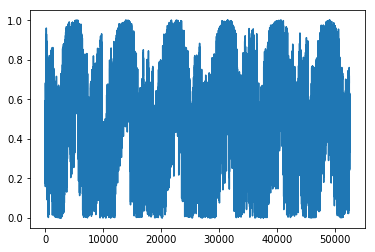

In [21]:
plt.plot(train_data_labels)

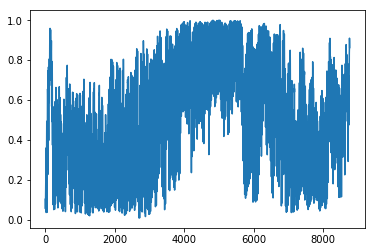

In [22]:
plt.plot(val_data_labels)

In [23]:
train_data_labels[24:,0].shape

(52536,)

In [30]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch import optim
import numpy as np

class SimpleRNN(nn.Module):
    def __init__(self, hidden_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        
        #self.inp = nn.Linear(5, hidden_size)
        self.inp = nn.Linear(1, hidden_size)
        #self.rnn = nn.RNN(hidden_size, hidden_size, nonlinearity='tanh')
        self.rnn = nn.LSTM(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, 1)

    def step(self, input, hidden=None):
        #input = self.inp(input.view(1, 5)).unsqueeze(1) #-1 means unsure of number of rows
        input = self.inp(input.view(1,-1)).unsqueeze(1)
        output, hidden = self.rnn(input, hidden)
        output = self.out(output.squeeze(1))
        return output, hidden
    
    def forward(self, inputs, hidden=None, force=True, steps=0):
        steps = len(inputs)
        outputs = Variable(torch.zeros(steps, 1, 1)) #.cuda()
        for i in range(steps):
            #input = inputs[i,:]
            input = inputs[i]
            output, hidden = self.step(input, hidden)
            outputs[i] = output
        return outputs, hidden

    """
    def forward(self, inputs, hidden=None, force=True, steps=0):
        if force or steps == 0: steps = len(inputs)
        outputs = Variable(torch.zeros(steps, 1, 1))
        for i in range(steps):
            if force or i == 0:
                input = inputs[i,:]
            else:
                input = output
            output, hidden = self.step(input, hidden)
            outputs[i] = output
        return outputs, hidden
    """

n_epochs = 500
n_iters = 10
hidden_size = 72

model = SimpleRNN(hidden_size) #.cuda()
#criterion = nn.SmoothL1Loss()
criterion = nn.L1Loss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

losses = np.zeros(n_epochs) # For plotting
val_errs = np.zeros(n_epochs)

In [31]:
print(val_data[0,:-24].shape)
print(val_data_labels[24:,0].shape)

(8736,)
(8736,)


In [32]:
for epoch in range(n_epochs):
    for iter in range(n_iters):
        #_inputs = sample(50)
        inputs = torch.from_numpy(train_data_vec[:-24,]).float()
        inputs = Variable(inputs) #cuda()
        targets = torch.from_numpy(train_data_labels[24:,0]).float()
        targets = Variable(targets) #.cuda()

        # Use teacher forcing 50% of the time
        force = np.random.random() < 0.1
        outputs, hidden = model(inputs, None, force)

        optimizer.zero_grad()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        losses[epoch] += loss.data[0]
        
        #validation error
        input_val = val_data[0,:-24]
        target_val = val_data_labels[24:,0]
        val_inputs = Variable(torch.from_numpy(input_val)).float() #.cuda()
        val_targets = Variable(torch.from_numpy(target_val)).float() #.cuda()
        val_outputs, hidden = model(val_inputs, hidden)
        val_loss = criterion(val_outputs, val_targets)
        
        val_errs[epoch] += val_loss.data[0]

    if epoch > 0:
        print(epoch, "Training loss: " + str(loss.data[0]))
        
        #train error
        print(epoch, "Val loss: " + str(val_loss.data[0]))

1 Training loss: 0.2500612139701843
1 Val loss: 0.2382587194442749
2 Training loss: 0.2500605881214142
2 Val loss: 0.23824916779994965
3 Training loss: 0.25006064772605896
3 Val loss: 0.2382500022649765
4 Training loss: 0.2500608563423157
4 Val loss: 0.23825044929981232
5 Training loss: 0.2500607967376709
5 Val loss: 0.23825114965438843
6 Training loss: 0.25006070733070374
6 Val loss: 0.23825111985206604
7 Training loss: 0.25006067752838135
7 Val loss: 0.23825159668922424
8 Training loss: 0.2500605583190918
8 Val loss: 0.23825207352638245
9 Training loss: 0.2500605881214142
9 Val loss: 0.23825271427631378
10 Training loss: 0.25006043910980225
10 Val loss: 0.23824773728847504
11 Training loss: 0.2500605881214142
11 Val loss: 0.23824813961982727
12 Training loss: 0.25006064772605896
12 Val loss: 0.2382487803697586
13 Training loss: 0.2500605881214142
13 Val loss: 0.23824910819530487
14 Training loss: 0.25006064772605896
14 Val loss: 0.23824989795684814
15 Training loss: 0.250060826539993

KeyboardInterrupt: 

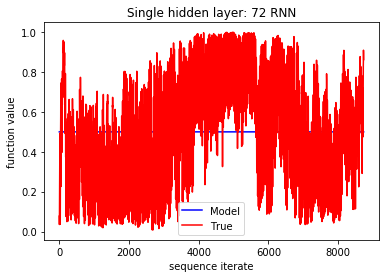

In [33]:
input_val = val_data[0,:-24]
target_val = val_data_labels[24:,0]
val_inputs = Variable(torch.from_numpy(input_val)).float()
val_outputs, hidden = model(val_inputs, hidden)

plt.plot(val_outputs.data.numpy()[:,0,0], color="blue", label="Model")
plt.plot(target_val, color="red", label="True")
plt.legend()
plt.title("Single hidden layer: " + str(hidden_size) + " RNN")
plt.xlabel("sequence iterate")
plt.ylabel("function value")
plt.show()

In [34]:
val_outputs.data.numpy()

array([[[ 0.50000286]],

       [[ 0.50000286]],

       [[ 0.50000286]],

       ..., 
       [[ 0.50000286]],

       [[ 0.50000286]],

       [[ 0.50000286]]], dtype=float32)

In [11]:
#build_model
import numpy as np
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

def rnn_lstm(layers, params):
    """Build RNN (LSTM) model on top of Keras and Tensorflow"""

    model = Sequential()
    model.add(LSTM(input_shape=(layers[1], layers[0]), output_dim=layers[1], return_sequences=True))
    model.add(Dropout(params['dropout_keep_prob']))
    model.add(LSTM(layers[2], return_sequences=False))
    model.add(Dropout(params['dropout_keep_prob']))
    model.add(Dense(output_dim=layers[3]))
    model.add(Activation("tanh"))

    model.compile(loss="mean_absolute_error", optimizer="adagrad")
    return(model)

def predict_next_timestamp(model, history):
    """Predict the next time stamp given a sequence of history data"""

    prediction = model.predict(history)
    prediction = np.reshape(prediction, (prediction.size,))
    return(prediction)

Using TensorFlow backend.


In [12]:
print("train_data: " + str(train_data.shape))
print("train_data_labels: " + str(train_data_labels.shape))
print("train_data_vec: " + str(train_data_vec.shape))
print("val_data: " + str(val_data.shape))
print("val_data_labels: " + str(val_data_labels.shape))

all_x_vec = np.concatenate((train_data_vec, val_data), axis=0)
all_x_vec = all_x_vec[:,np.newaxis]
all_y_vec = np.concatenate((train_data_labels, val_data_labels), axis = 0)
print(all_x_vec.shape)
print(all_y_vec.shape)

train_data: (6, 8760)
train_data_labels: (52560, 1)
train_data_vec: (52560,)
val_data: (8760,)
val_data_labels: (8760, 1)
(61320, 1)
(61320, 1)


In [13]:
#data_helper
import numpy as np
import pandas as pd

def load_timeseries(params):
    
    adjusted_window = params['window_size'] + 1

    # Split data into windows
    raw_x = []
    for index in range(all_x_vec.shape[0] - adjusted_window):
        raw_x.append(all_x_vec[index: index + adjusted_window, 0])

    raw_y = []
    for index in range(all_y_vec.shape[0] - adjusted_window):
        raw_y.append(all_y_vec[index: index + adjusted_window, 0])
        
    data_x = np.array(raw_x)
    data_y = np.array(raw_y)

    # Split the input dataset into train and test
    split_ratio = round(params['train_test_split'] * data_x.shape[0])
    train_x = data_x[:int(split_ratio), :-24]
    train_y = data_y[:int(split_ratio), -24:]
    #np.random.shuffle(train)

    # x_test and y_test, for testing
    val_x = data_x[int(split_ratio):, :-24]
    val_y = data_y[int(split_ratio):, -24:]

    train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1))
    train_y = np.reshape(train_y, (train_y.shape[0], train_y.shape[1], 1))
    val_x = np.reshape(val_x, (val_x.shape[0], val_x.shape[1], 1))  
    val_y = np.reshape(val_y, (val_y.shape[0], val_y.shape[1], 1))

    # Last window, for next time stamp prediction
    #last_raw = [all_x_vec[-params['window_size']:]]
    #last = np.array(last)
    #last = np.reshape(last, (last.shape[0], last.shape[1], 1))

    return [train_x, train_y, val_x, val_y]

In [17]:
print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)


(48767, 337, 1)
(48767, 24, 1)
(12192, 337, 1)
(12192, 24, 1)


In [34]:
# Load training parameters
params = {"epochs": 2,\
          "batch_size": 200,\
          "window_size": 72*5,\
          "train_test_split": 0.8,\
          "validation_split": 0.1,\
          "dropout_keep_prob": 0.2,\
          "hidden_unit": 72}

# Load time series dataset, and split it into train and test
train_x, train_y, val_x, val_y = load_timeseries(params)

# Build RNN (LSTM) model
lstm_layer = [1, train_x.shape[1], params['hidden_unit'], 24]
model = rnn_lstm(lstm_layer, params)

# Train RNN (LSTM) model with train set
model.fit(
    train_x,
    train_y[:,:,0],
    batch_size=params['batch_size'],
    epochs=params['epochs'])
    #validation_data=(val_x, val_y))

# Check the model against test set
#for i in range(val_x.shape[0]):
#    predicted = predict_next_timestamp(model, val_x[i,:,0])        

# Plot graph: predicted VS actual
#plt.subplot(111)
#plt.plot(predicted, label='Actual')
#plt.plot(val_y[, label='Predicted')	
#plt.legend()
#plt.show()

# Predict next time stamp 
#next_timestamp = build_model.predict_next_timestamp(model, last_window)
#next_timestamp_raw = (next_timestamp[0] + 1) * last_window_raw[0][0]
#print('The next time stamp forecasting is: {}'.format(next_timestamp_raw))

/home/chase/applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(337, 1), return_sequences=True, units=337)`
/home/chase/applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=24)`


Epoch 1/2
48767/48767 [==============================] - 3201s 66ms/step - loss: 0.2614
Epoch 2/2
48767/48767 [==============================] - 3252s 67ms/step - loss: 0.2545


In [52]:
out = model.predict(val_x[np.newaxis,100,:])

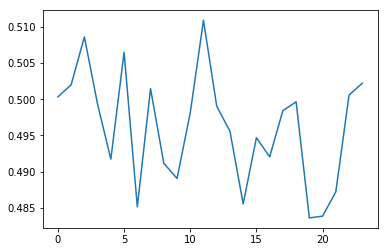

In [53]:
plt.plot(out.T)

In [54]:
val_x

array([[[ 45829.26032496],
        [ 43140.67838396],
        [ 41209.05494696],
        ..., 
        [ 54343.54958196],
        [ 49940.98888   ],
        [ 46060.09908196]],

       [[ 43140.67838396],
        [ 41209.05494696],
        [ 39982.94601496],
        ..., 
        [ 49940.98888   ],
        [ 46060.09908196],
        [ 43131.93158596]],

       [[ 41209.05494696],
        [ 39982.94601496],
        [ 39602.05138496],
        ..., 
        [ 46060.09908196],
        [ 43131.93158596],
        [ 41093.42581195]],

       ..., 
       [[ 42110.856493  ],
        [ 41232.760731  ],
        [ 39697.956625  ],
        ..., 
        [ 43182.317618  ],
        [ 43226.950194  ],
        [ 43121.988315  ]],

       [[ 41232.760731  ],
        [ 39697.956625  ],
        [ 37847.927974  ],
        ..., 
        [ 43226.950194  ],
        [ 43121.988315  ],
        [ 42547.359716  ]],

       [[ 39697.956625  ],
        [ 37847.927974  ],
        [ 36121.683009  ],
        ..., 
  